# Exploratory Data Analysis — NRAR Enforcement and Compliance Data

## Imports

In [54]:
import pandas as pd
import qgrid
from pivottablejs import pivot_ui
import plotly
import plotly.express as px
import missingno as msno
from datetime import datetime
%matplotlib inline
%config Completer.use_jedi = False

## Load data

Create a custom date parser

In [55]:
custom_date_parser = lambda x: datetime.strptime(x, "%b-%y")

Load compliance data from CSV files

In [56]:
nan_values_list = ["NaN",' ']

df_casedetails=pd.read_csv('Case Details.csv', na_values=nan_values_list, parse_dates=['Received Date','Finalisation Date'], date_parser=custom_date_parser, index_col=0)
df_enfactions_count=pd.read_csv('Enforcement actions — count.csv', na_values=nan_values_list, index_col=0)
df_enfactions_description=pd.read_csv('Enforcement actions — description.csv', parse_dates=['Enforcement Action Date'], date_parser=custom_date_parser, na_values=nan_values_list, index_col=0)

Reformat dates to display as month-year

In [57]:
df_casedetails['Received Date'] = df_casedetails['Received Date'].dt.strftime("%b-%y")
df_casedetails['Finalisation Date'] = df_casedetails['Finalisation Date'].dt.strftime("%b-%y")
df_enfactions_description['Enforcement Action Date'] = df_enfactions_description['Enforcement Action Date'].dt.strftime("%b-%y")

Sort Case Details table by received date

In [58]:
df_casedetails.sort_values('Received Date', inplace=True)

### Verify that data was imported correctly

#### Case Details

Qgrid viz

In [59]:
qgrid.show_grid(df_casedetails)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Check data completeness

<AxesSubplot:>

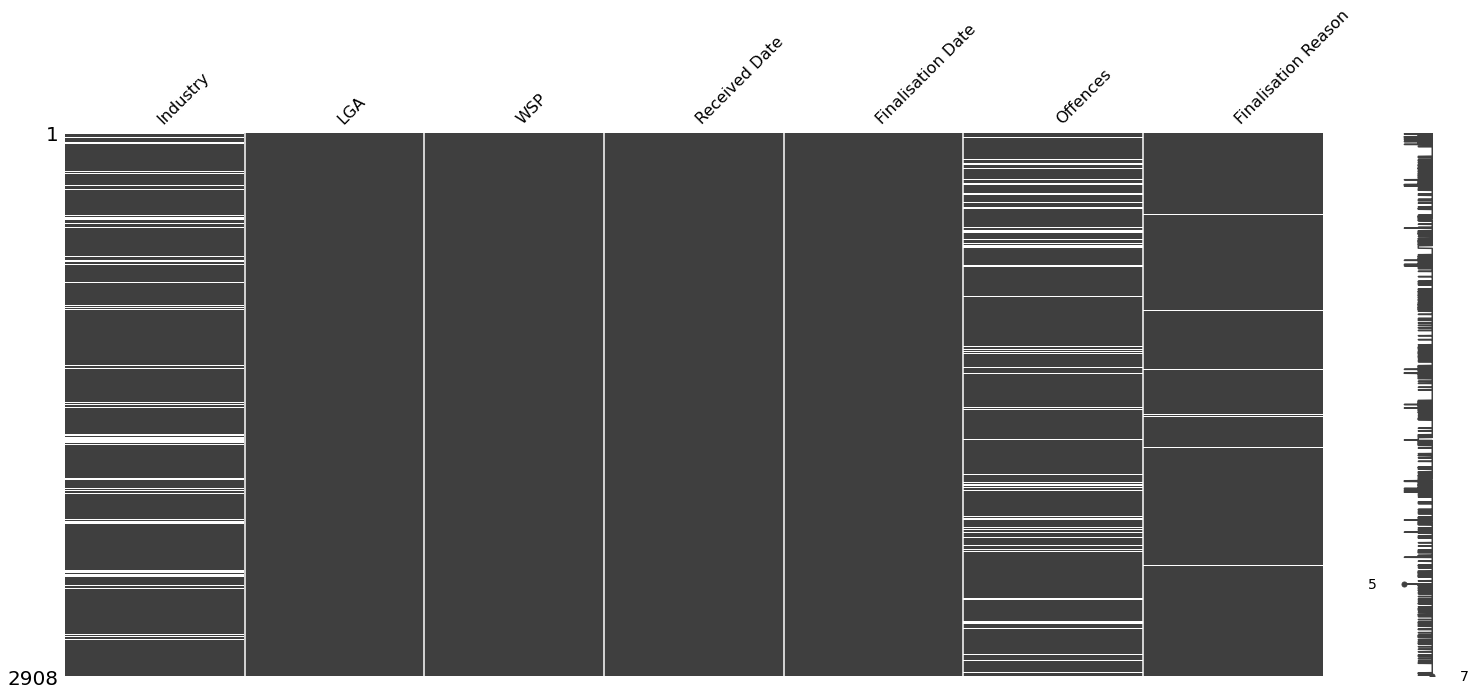

In [60]:
msno.matrix(df_casedetails)

#### Enforcement Actions — Count

Qgrid viz

In [61]:
qgrid.show_grid(df_enfactions_count)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Check data completeness

<AxesSubplot:>

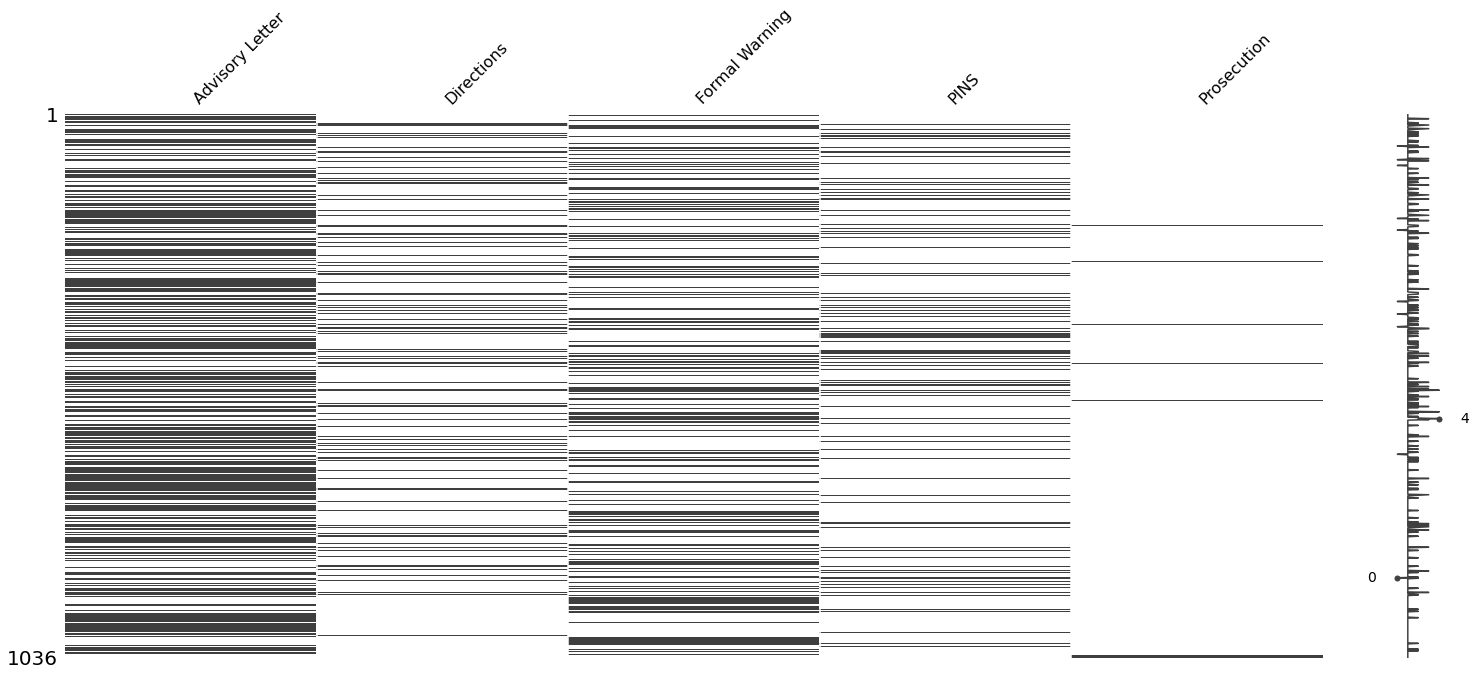

In [62]:
msno.matrix(df_enfactions_count)

#### Enforcement Actions — Description

Qgrid viz

In [63]:
qgrid.show_grid(df_enfactions_description)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Pivot Tables

### Case Details

In [64]:
pivot_ui(df_casedetails)

### Enforcement Actions — Description

In [65]:
pivot_ui(df_enfactions_description)

# SANDPIT

## Plotly — Sunburst

### Case Details

List data columns

In [66]:
list(df_casedetails.columns)

['Industry',
 'LGA',
 'WSP',
 'Received Date',
 'Finalisation Date',
 'Offences',
 'Finalisation Reason']

Set groupy path, choose sequence of data headers from the above list

In [86]:
groupby_path = ['Offences','Finalisation Reason','LGA']

Create path title for plot

In [87]:
path_title = ', '.join(groupby_path)

Apply groupby and reset to Dataframe so that Plotly can read it

In [88]:
df = df_casedetails.groupby(groupby_path).count().reset_index()
df['count'] = df.iloc[:,-1:]

Create Sunburst plot

In [89]:
fig = px.sunburst(df, path=groupby_path, values='count', width=900, height=900)
fig.update_layout(title=path_title)
fig.show()
fig.write_html("Case_Details_Sunburst.html")

## Plotly — Treemap

List data columns

In [71]:
list(df_casedetails.columns)

['Industry',
 'LGA',
 'WSP',
 'Received Date',
 'Finalisation Date',
 'Offences',
 'Finalisation Reason']

Set groupy path, choose sequence of data headers from the above list

In [72]:
groupby_path = ['Finalisation Date','Received Date','Finalisation Reason']

Create path title for plot

In [73]:
path_title = ', '.join(groupby_path)

Apply groupby and reset to Dataframe so that Plotly can read it

In [74]:
df = df_casedetails.groupby(groupby_path).count().reset_index()
df['count'] = df.iloc[:,-1:]

Create Sunburst plot

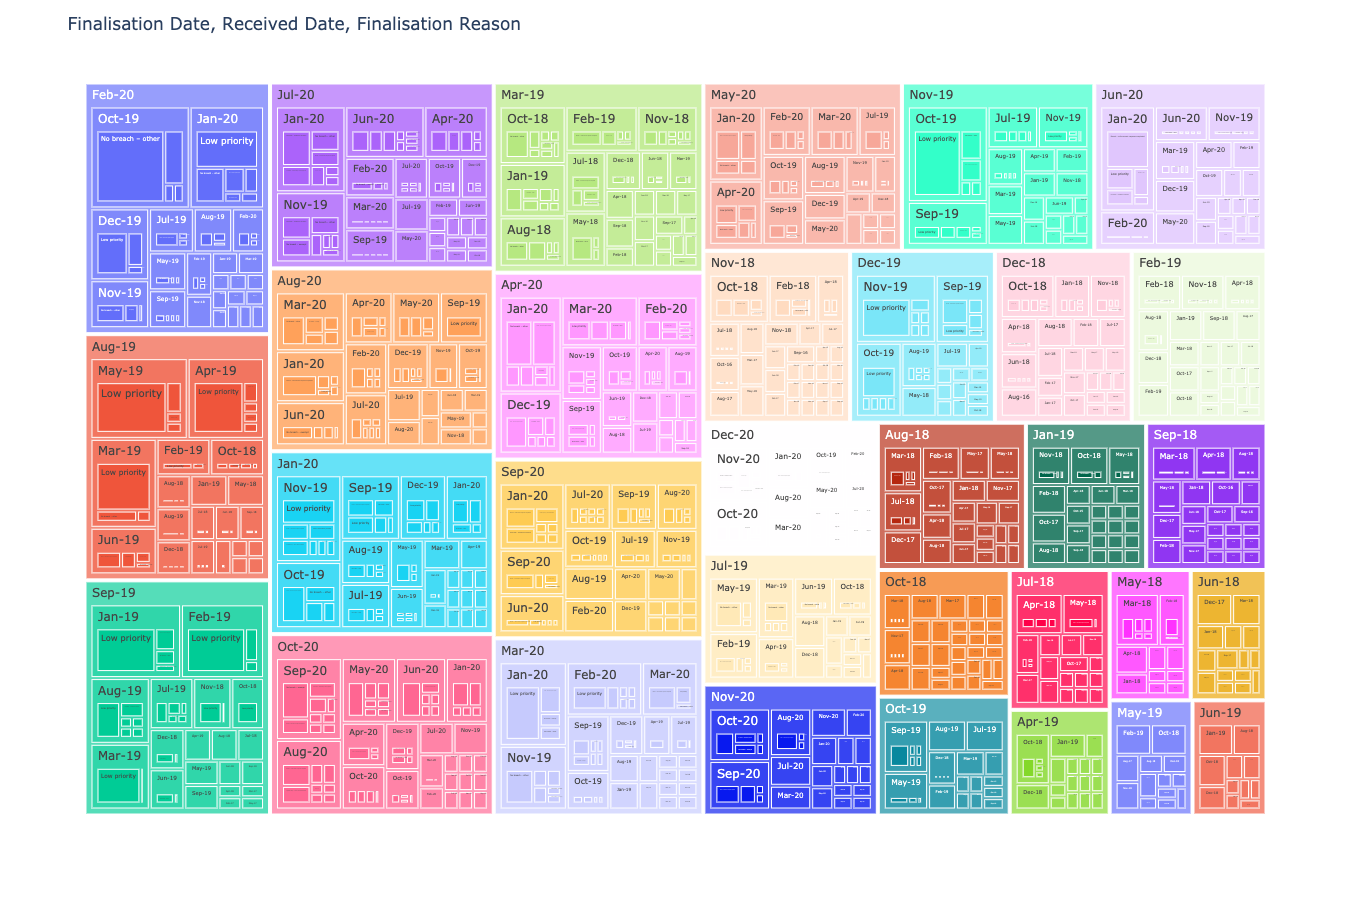

In [75]:
fig = px.treemap(df, path=groupby_path, values='count', width=900, height=900)
fig.update_layout(title=path_title)
fig.show()
fig.write_html("Case_Details_Treemap.html")

## Plotly — Sankey

List data columns

In [76]:
list(df_casedetails.columns)

['Industry',
 'LGA',
 'WSP',
 'Received Date',
 'Finalisation Date',
 'Offences',
 'Finalisation Reason']

Set groupy path, choose sequence of data headers from the above list

In [77]:
groupby_path = ['Industry','Finalisation Reason']

Create path title for plot

In [78]:
path_title = ', '.join(groupby_path)

Apply groupby and reset to Dataframe so that Plotly can read it

In [79]:
df = df_casedetails.groupby(groupby_path).count().reset_index()
df['count'] = df.iloc[:,-1:]

Apply wrapper function for Plotly Sankey plot, see: https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0

In [80]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        width=1000, 
        height=1000,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

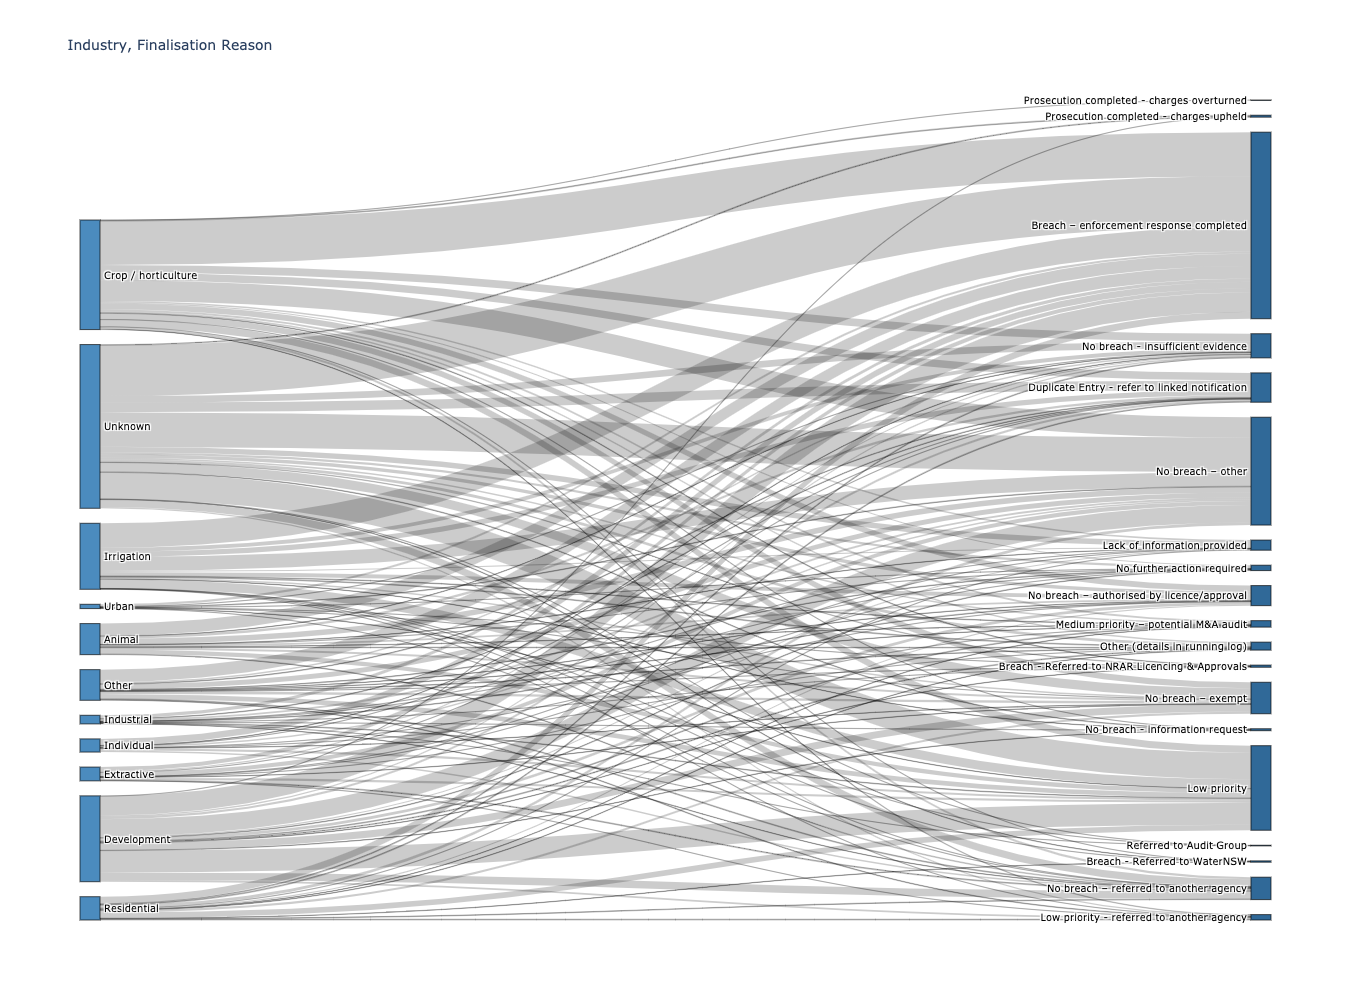

In [81]:
fig = genSankey(df,cat_cols=groupby_path, value_cols='WSP', title=path_title)
plotly.io.show(fig, validate=True)

# Analysis

## Insights

## To do